# [Computational Social Science] Project 5: Natural Language Processing 

**Name**: Takun Wang  
**Date**: February 24, 2024

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# load packages
# ----
import pandas as pd; print(pd.__version__)
import numpy as np

# preprocessing
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2.0.3


In [2]:
# load data 
# ----
tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [3]:
# inspect
print(tweets.shape, '\n\n',
      'number of figures:', tweets['name_wikipedia'].nunique(), '\n\n',
      tweets.groupby('name_wikipedia')['party'].unique().value_counts(), '\n\n',
      tweets['party'].value_counts(), '\n\n', 
      tweets['position'].value_counts())

(946791, 16) 

 number of figures: 455 

 party
[Democrat]       242
[Republican]     211
[Independent]      2
Name: count, dtype: int64 

 party
Democrat       606967
Republican     336068
Independent      3756
Name: count, dtype: int64 

 position
Rep    725513
Sen    221278
Name: count, dtype: int64


In [4]:
# sample a subset of data (for the limitation of computational resources)
## here I sample it in a way to balance # of tweets from Democrats and Republicans
# ----
tweets = pd.concat([tweets[tweets['party'] == 'Democrat'].sample(7500, random_state = 224), 
                    tweets[tweets['party'] == 'Republican'].sample(7500, random_state = 224)]).reset_index(drop = True)

In [5]:
# inspect again 
print(tweets.shape, '\n\n',
      'number of figures:', tweets['name_wikipedia'].nunique(), '\n\n',
      tweets.groupby('name_wikipedia')['party'].unique().value_counts(), '\n\n',
      tweets['party'].value_counts(), '\n\n', 
      tweets['position'].value_counts())

(15000, 16) 

 number of figures: 450 

 party
[Democrat]      239
[Republican]    211
Name: count, dtype: int64 

 party
Democrat      7500
Republican    7500
Name: count, dtype: int64 

 position
Rep    11254
Sen     3746
Name: count, dtype: int64


## 1. Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [6]:
# define punctuation
# ----

# update some other punctuations (e.g. fullwidth quotation marks)
punc = set(punctuation)
punc.update({'”', '"', '’', '—', '–'})

# remove '@' (mention) from the set
punc = punc - {'@'}

print(punc)

{'?', '%', '&', '(', '/', '”', '>', '"', ':', '_', ';', '–', '$', ')', '-', '=', '~', "'", ']', '.', '<', '{', '!', '`', '}', '—', '*', '#', '\\', '+', '’', '^', '|', '[', ','}


In [7]:
# add stop words (e.g. punctuation "&" in html format is "&amp;")
# ----
STOP_WORDS.update({'amp', 'w', ' ', '  ', '   ', '    '})

In [8]:
def tokenize_func(txt): 
    
    # lowercase
    txt = txt.lower()
    
    # replace some texts
    txt = txt.replace('\n\n', ' ')       # line breaks
    txt = txt.replace('\n', ' ')
    txt = txt.replace('#', '@')          # hashtags
    
    # remove puctuation 
    txt = ''.join([ch for ch in txt if ch not in punc])
    
    # tokenize the text
    words = [token.lemma_.lower() for token in nlp(txt)]
    
    # filter out URLs and stop words
    words = [w for w in words if w not in STOP_WORDS]
    words = [w for w in words if not w.startswith('http')]
    
    return words

In [9]:
# check 
txt = tweets['text'][224]
txt

'DREAMers: your #HomeIsHere.\n\nThis is a major victory, and I will continue fighting for a permanent solution for our nation’s DREAMers and their families to have a path to citizenship in the country they call home.\nhttps://www.nbcnews.com/politics/supreme-court/supreme-court-rules-trump-cannot-end-daca-big-win-dreamer-n1115116'

In [10]:
# check
print(tokenize_func(txt))

['dreamer', '@homeishere', 'major', 'victory', 'continue', 'fight', 'permanent', 'solution', 'nation', 'dreamer', 'family', 'path', 'citizenship', 'country', 'home']


In [11]:
# apply the tokenize function to all the 15,000 columns (~3 min computing time)
# ----
tweets['tokens'] = tweets['text'].map(lambda x: tokenize_func(x)) 
tweets['tokens'] 

0        [tune, @msnbc, today, 1130am, segment, @katytu...
1        [bud, tech, enthusiast, coder, engineer, innov...
2        [join, @speakerpelosi, prepare, vote, @hr6, am...
3        [rt, @zackhawkinsnc, dr, ronda, taylorbullock,...
4        [@endqualifiedimmunity, pass, rep, pressley, @...
                               ...                        
14995    [@lifelibertylevin, start, tune, @foxnews, @ma...
14996    [house, democrats, risk, safety, security, fre...
14997    [news, @jiminhofe, lead, letter, urge, epa, co...
14998    [pleasure, visit, ms, barrett, early, today, e...
14999    [proud, support, pay, family, leave, @fy20ndaa...
Name: tokens, Length: 15000, dtype: object

In [12]:
# turn the tokens into text 
# ----
tweets['tokens_text'] = tweets['tokens'].map(lambda text: ' '.join(text))

In [13]:
# count # of tokens
tweets['tokens_count'] = tweets['tokens'].map(lambda x: len(x))

In [14]:
# check
tweets['tokens_text'][224]

'dreamer @homeishere major victory continue fight permanent solution nation dreamer family path citizenship country home'

In [15]:
tweets['tokens_count'][224]

15

In [17]:
# check (51 tweets w/o tokens)
print(len(tweets[tweets['tokens_count'] == 0]))
tweets[tweets['tokens_count'] == 0].head()

51


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_text,tokens_count
334,1.213870e+18,RepJoeMorelle,2020-01-05T11:53:37-05:00,http://pbs.twimg.com/media/ENiE0wFWkAUzC8J.jpg...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",[],,0
749,1.294290e+18,RepAndreCarson,2020-08-14T10:54:32-04:00,http://pbs.twimg.com/media/EfY6W-dXoAIdZmc.png,André Carson,Rep,11-Mar-08,10/16/1974,M,IN,7,Democrat,"1,557,286","1,033,126","1,152,887","1,420,543",[],,0
1615,1.320410e+18,RepJahanaHayes,2020-10-25T12:42:17-04:00,http://pbs.twimg.com/media/ElMFpkZXUAAR05O.jpg,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,5,Democrat,"673,215","897,572","905,083","634,892",[],,0
1727,1.249080e+18,RepKirkpatrick,2020-04-11T17:00:43-04:00,http://pbs.twimg.com/media/EVWfmlTWAAE8CAR.jpg,Ann Kirkpatrick,Rep,3-Jan-19,3/24/1950,F,AZ,2,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654",[],,0
2294,1.318580e+18,RepJahanaHayes,2020-10-20T11:29:41-04:00,http://pbs.twimg.com/media/EkyFFVLXEAMHtbN.jpg,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,5,Democrat,"673,215","897,572","905,083","634,892",[],,0


In [22]:
# drop tweets w/o tokens
tweets = tweets[tweets['tokens_count'] != 0].reset_index(drop = True)
tweets.shape

(14949, 19)

## 2. Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### 2.1. EDA 1: Scattertext

In [14]:
# load packages 
# ----
import scattertext as st

In [15]:
# create corpus
# ----
corpus = st.CorpusFromPandas(
    tweets,
	category_col = 'party',     # specify the explanatory variable  
	text_col = 'tokens_text',   # specify the text column
	nlp = nlp).build()          # apply the nlp algorithim and build

In [16]:
# create html document
# ----
html = st.produce_scattertext_explorer(
    corpus,
	category = 'Democrat',
	category_name = 'Democrat',
	not_category_name = 'Republican',
	minimum_term_frequency = 5,
	width_in_pixels = 1000,
	metadata = corpus.get_df()['name_wikipedia'])

# write html document 
open("export/tweets_st.html", 'wb').write(html.encode('utf-8'))

3895900

**Output Screeshot:**
![title](export/tweets_st.png)

### 2.2. EDA 2: Word Counts

In [23]:
# load packages
# ----
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# test a count vectorizer
# ----
count = CountVectorizer()
count_mx = count.fit_transform(tweets['tokens_text'][0:2])

# convert matrix to dataframe
count_df = pd.DataFrame(
    data = count_mx.toarray(),   
	columns = count.get_feature_names_out()) 

count_df.iloc[1]

1130am                 0
app                    1
article                0
bring                  0
bud                    1
chance                 1
coder                  1
congressionalac        1
defendourdemocracy     0
donald                 0
engineer               1
enthusiast             1
historic               0
impeachment            0
impeachmenthearings    0
innovator              1
katyturnbc             0
msnbc                  0
nj11                   1
segment                0
submit                 1
tech                   1
today                  0
trump                  0
tune                   0
vote                   0
Name: 1, dtype: int64

In [25]:
# check (make sure the vectorizer did work as expected)
print(tweets['tokens_text'][1], '\n\n',
      '----original text as follows----', '\n\n',
      tweets['text'][1])

bud tech enthusiast coder engineer innovator @nj11 chance submit app @congressionalac 

 ----original text as follows---- 

 Calling all budding tech enthusiasts, coders, engineers, and innovators in #NJ11! This is your last chance to submit your apps for the @CongressionalAC! http://pbs.twimg.com/media/EIJAIQdWoAEOrq3.png


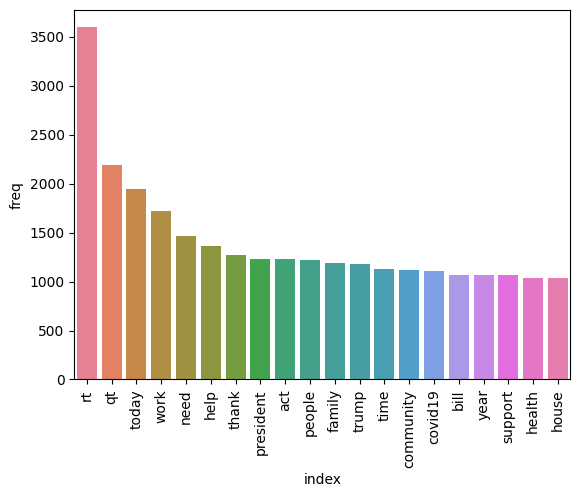

In [26]:
# plot most frequent unigrams 
count = CountVectorizer(min_df = 5) 
count_mx = count.fit_transform(tweets['tokens_text'])

# convert matrix to an arrray and then to a dataframe
count_df = pd.DataFrame(
    count_mx.toarray(), 
    columns = count.get_feature_names_out()) 

# create dictionary and sort it by frequency
dic = pd.DataFrame(count_df.sum(), columns=['freq'])
dic = dic.sort_values(
	by = ['freq'], 
	ascending = False).reset_index()

# plot 
sns.barplot(x = 'index', 
            y = 'freq', 
            hue = 'index', 
            data = dic[0:20])
plt.xticks(rotation=90);

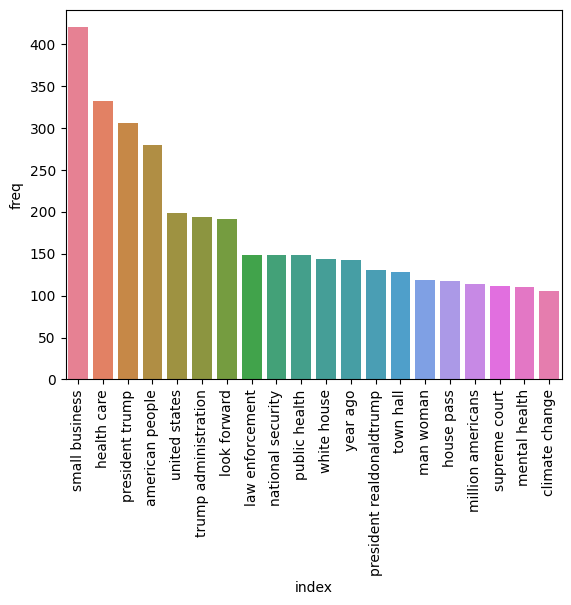

In [27]:
# plot most frequent bigrams 
count = CountVectorizer(min_df = 5, ngram_range = (2,2))
count_mx = count.fit_transform(tweets['tokens_text'])

# convert matrix to an arrray and then to a dataframe
count_df = pd.DataFrame(
    count_mx.toarray(), 
    columns = count.get_feature_names_out()) 

# create dictionary and sort it by frequency
dic = pd.DataFrame(count_df.sum(), columns=['freq'])
dic = dic.sort_values(
	by = ['freq'], 
	ascending = False).reset_index()

# plot 
sns.barplot(x = 'index', 
            y = 'freq', 
            hue = 'index', 
            data = dic[0:20])
plt.xticks(rotation=90);

### 2.3. EDA 3: Topic Modeling

In [28]:
# load packages
# ----
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [29]:
# create tf-idf matrix
# ----
tfidf = TfidfVectorizer(min_df = 5)  # ignore terms that have a document frequency less than 5 (cut-off)
tfidf_mx = tfidf.fit_transform(tweets['tokens_text'])

# convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(
	data = tfidf_mx.toarray(),
	columns = tfidf.get_feature_names_out())

tfidf_df.head()

,10,100,1000,10000,100000,100k,100th,101,102,1030,...,yovanovitch,yr,yrs,zachary,zelensky,zero,zip,zone,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# check (ten largest tfidf words in doc #1)
tfidf_df.T.nlargest(10, 1)

,0,1,2,3,4,5,6,7,8,9,...,14939,14940,14941,14942,14943,14944,14945,14946,14947,14948
bud,0.0,0.414665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
innovator,0.0,0.397600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
congressionalac,0.0,0.393039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
engineer,0.0,0.359875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
app,0.0,0.328936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
submit,0.0,0.314324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tech,0.0,0.302487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chance,0.0,0.295771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# train adn fit a LDA model
# ----
lda = LatentDirichletAllocation(
	n_components = 5,    # adjust the # of components
	max_iter = 20,       # adjust the # of iterations to fit model
	random_state = 224)  # set seed for reproducibility

lda.fit(tfidf_mx)

LatentDirichletAllocation(max_iter=20, n_components=5, random_state=224)

In [32]:
# view the top words of each topic
# ----
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):  # iterate over each topic 
        print("\ntopic_{}:".format(topic_idx))            # print topic index
        print(" ".join([feature_names[i]                   # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda,                             # model 
                tfidf.get_feature_names_out(),   # feature names 
                20)                              # number of top words


topic_0:
covid19 rt join pm visit tune county discuss office de live coronavirus town help update hall today information stay question

topic_1:
rt president trump qt realdonaldtrump people house vote american election democrats impeachment border congress right administration time security china report

topic_2:
today community work thank life act woman rt fight day right protect family year time support law veteran need proud

topic_3:
thank great honor rt congratulation today serve service year happy day good qt nation work country member state proud student

topic_4:
business need work help small health worker care relief bill rt family million act support pass program covid19 job provide



In [33]:
# get the topic distribution and calculate group mean
# ----
col_names = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']
topic_dist = pd.DataFrame(
    lda.transform(tfidf_mx),
    columns = col_names)

# join back to pandas dataframe and reset index
tweets = tweets.join(topic_dist)

# group by loan products and calculate mean
for i in col_names:
    print(tweets.groupby('party')[i].agg('mean'), '\n')

party
Democrat      0.155783
Republican    0.166348
Name: topic_0, dtype: float64 

party
Democrat      0.267667
Republican    0.280755
Name: topic_1, dtype: float64 

party
Democrat      0.228332
Republican    0.178759
Name: topic_2, dtype: float64 

party
Democrat      0.118710
Republican    0.163773
Name: topic_3, dtype: float64 

party
Democrat      0.229507
Republican    0.210364
Name: topic_4, dtype: float64 



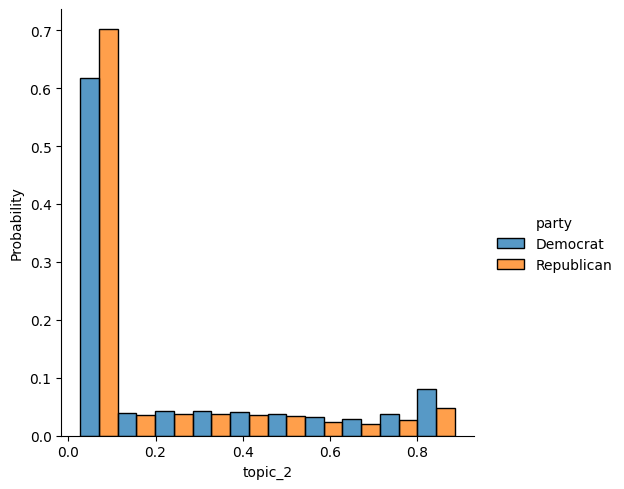

In [34]:
# plot distribution of topic 2
## democrats seem to be tweeting more about topic 2
sns.displot(tweets, 
            x = tweets['topic_2'],
            hue = 'party',   
            multiple = 'dodge',
            stat = 'probability',
            common_norm = False,
            bins = 10)
plt.show()

## 3. Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

### 3.1. Polarity Scores 

In [35]:
# load packages
# ----
from textblob import TextBlob

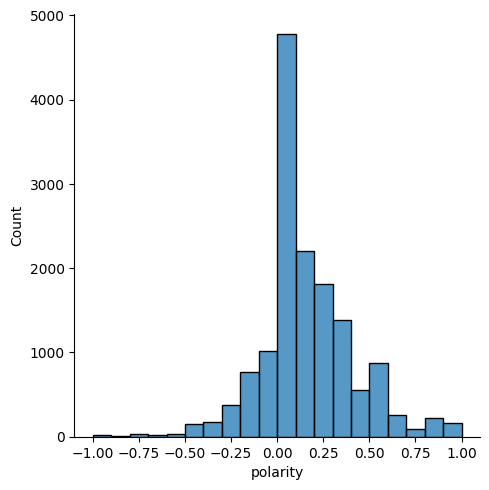

In [36]:
# create polarity column
# ----
tweets['polarity'] = tweets['text'].map(lambda text: TextBlob(text).sentiment.polarity)

# plot
sns.displot(tweets,
            x = 'polarity',
            bins = 20);

In [37]:
# view the 5 most positive tweets
print('5 most positive tweets: \n')
for t in tweets.nlargest(5, 'polarity')['text']:
    print('---- \n', t, '\n')

5 most positive tweets: 

---- 
 Incredible story. Never stop singing, Lavender! Thank you for being you. 

http://www.sentinelandenterprise.com/news/ci_32704388/video-blind-autistic-fitchburg-singer-goes-viral 

---- 
 RT @patagonia Thank you @BettyMcCollum04, @NRDems, @savethebwca, @sportsmenbwca, @Backcountry_H_A &amp; everyone else for your work to help push HR5598 through the committee and to the floor in order to protect the Boundary Waters!
#savethebwca https://twitter.com/savethebwca/status/1311454204909633541 QT @savethebwca Great news for the Boundary Waters! @BettyMcCollum04’s bill to protect the BWCA from mining just passed committee and heads to the floor. Join us in thanking Rep. McCollum for her leadership to #savethebwca
http://savetheboundarywaters.org/updates/hr5598-passes-out-us-house-natural-resources-committee http://pbs.twimg.com/media/EjM4l1XU8AArBZM.jpg 

---- 
 Want to wish my dear friend, colleague, and Fab Four sister @RepDean a very happy birthday! Cheers to

In [38]:
# view the 5 most negative tweets
print('5 most negative tweets: \n')
for t in tweets.nsmallest(5, 'polarity')['text']:
    print('---- \n', t, '\n')

5 most negative tweets: 

---- 
 Horrific and unacceptable. @HouseJudiciary will demand justice for these children and their families and accountability from this administration.
https://www.politicususa.com/2019/05/28/democrats-demand-investigation-into-trump-migrant-child-deaths.html 

---- 
 Today, we recognize two years since the horrific shooting at the Tree of Life Synagogue in Pittsburgh. Anti-Semitic violence continues to persist in our country, and we must work together as Americans to stamp out all forms of intolerance and hatred. 

---- 
 “Doggett (D-San Antonio)..chairman of the House Ways &amp; Means Health Subcommittee, said Trump ‘could increase the supply and lower prices, and we’d have a surplus. Instead, we have physicians being placed in the horrible position of deciding who gets the drug &amp; who is abandoned.’” 

---- 
 RT @theappeal .@RepPressley: "Has the president or any member of the [coronavirus] task force raised clemency power as a method of preventing a po

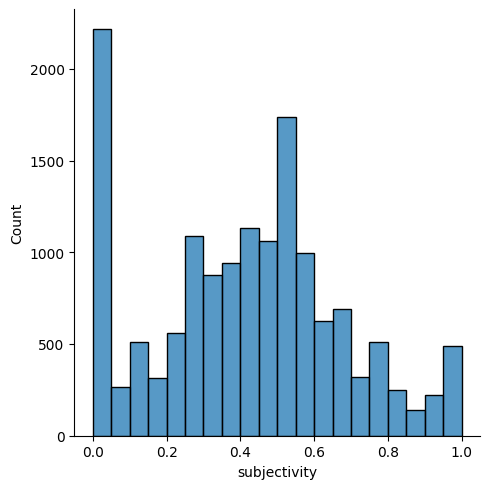

In [39]:
# create subjectivity column
# ----
tweets['subjectivity'] = tweets['text'].map(lambda text: TextBlob(text).sentiment.subjectivity)

# plot
sns.displot(tweets,
            x = "subjectivity",
            bins = 20);

In [40]:
# view the 5 most subjective tweets
print('5 most subjective tweets: \n')
for t in tweets.nlargest(5, 'subjectivity')['text']:
    print('---- \n', t, '\n')

5 most subjective tweets: 

---- 
 The passing of Aimee Stephens, who led the fight for transgender equality to the Supreme Court, is a loss felt by all who work to end discrimination. I send my condolences to her family and all others mourning the loss of this brave advocate for justice.
https://www.nytimes.com/2020/05/12/us/aimee-stephens-supreme-court-dead.html 

---- 
 RT @SenWhitehouse Soon, we will be voting on whether extreme @realDonaldTrump judicial nominee Steven Menashi deserves a lifetime seat on the federal bench. 

The problem is… he refused to answer ANY of our questions, Republicans and Democrats alike. http://pbs.twimg.com/ext_tw_video_thumb/1182398493291417603/pu/img/cIGqoJCgsOodw0xT.jpg https://video.twimg.com/ext_tw_video/1182398493291417603/pu/vid/320x320/WZgrvSOKKO9NUjhb.mp4?tag=10 

---- 
 As colleges consider reopening this fall, it’s important to remember that students are susceptible to #COVID19. They can carry, spread, &amp; develop long-term health outcomes 

In [41]:
# view the 5 least subjective tweets
print('5 least subjective tweets: \n')
for t in tweets.nsmallest(5, 'subjectivity')['text']:
    print('---- \n', t, '\n')

5 least subjective tweets: 

---- 
 Tune in to @MSNBC today at 11:30am for my segment with @KatyTurNBC on today’s historic vote to bring articles of impeachment against Donald Trump.
#ImpeachmentHearings #DefendOurDemocracy 

---- 
 RT @zackhawkinsnc Dr. Ronda Taylor-Bullock, Executive Director @weare_org, will be our next guest on The Breakdown w/ @zackafhawkins to talk about the work that her org does around the systematic racism that plagues our country. 6/2 6:30p http://facebook.com/zackhawkinsnc#thebreakdownwithzack #abetternorthcarolina http://pbs.twimg.com/media/EZeBlrqX0AIHIR2.jpg 

---- 
 RT @HomelandDems Fact check: still not a crisis.  https://www.washingtonpost.com/politics/trump-used-the-oval-office-to-try-to-create-a-border-crisis/2019/01/08/13cbe77c-139b-11e9-803c-4ef28312c8b9_story.html 

---- 
 Estoy de acuerdo con la congresista @RepDMP https://twitter.com/alpunto/status/1147874157264138241 QT @AlPunto .@RepBMP dice que debe haber "consecuencias severas" tras la págin

In [42]:
# check one of the least subjective tweet
## polarity score seems to capture the sentiment of tweets better
## will focus on polarity score in visualization part
sample_tweet = "On Tuesday, March 12, 2019 at 7:30 AM ET, I am scheduled to appear on C-SPAN’s television program @cspanwj to discuss plans to impeach President Donald J. Trump. Contact your television provider for your local listing. Please plan to tune in. #ImpeachmentIsNotDead"

# print polarity score
print("overall subjectivity score is ", TextBlob(sample_tweet).sentiment.subjectivity)
for word in sample_tweet.split():
    print(word, TextBlob(word).sentiment.polarity)

overall subjectivity score is  0.0
On 0.0
Tuesday, 0.0
March 0.0
12, 0.0
2019 0.0
at 0.0
7:30 0.0
AM 0.0
ET, 0.0
I 0.0
am 0.0
scheduled 0.0
to 0.0
appear 0.0
on 0.0
C-SPAN’s 0.0
television 0.0
program 0.0
@cspanwj 0.0
to 0.0
discuss 0.0
plans 0.0
to 0.0
impeach 0.0
President 0.0
Donald 0.0
J. 0.0
Trump. 0.0
Contact 0.0
your 0.0
television 0.0
provider 0.0
for 0.0
your 0.0
local 0.0
listing. 0.0
Please 0.0
plan 0.0
to 0.0
tune 0.0
in. 0.0
#ImpeachmentIsNotDead 0.0


### 3.2. Visualization

In [43]:
# check 
## I'm going to compare Don Beyer with Andy Biggs, they are both a representative and tweet a lot
## Beyer is a democrat, while Biggs a republican. May be an interesting comparison
tweets['name_wikipedia'].value_counts()

name_wikipedia
John Cornyn       287
Andy Biggs        286
Don Beyer         166
Ted Cruz          158
Kevin McCarthy    120
                 ... 
David Trone         1
Ben Sasse           1
John Moolenaar      1
Kenny Marchant      1
James Inhofe        1
Name: count, Length: 450, dtype: int64

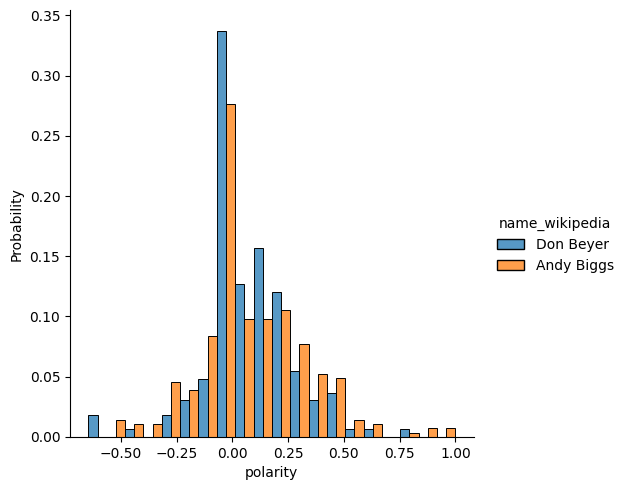

In [44]:
# plot sentiment of tweets from Beyer and Biggs
## overall, Bigg (R-rep) has more positive tweets than Beyer (D-rep)
sns.displot(tweets[(tweets['name_wikipedia'] == 'Don Beyer') | (tweets['name_wikipedia'] == 'Andy Biggs')],
            x = 'polarity',
            hue = 'name_wikipedia',
            multiple = 'dodge',
            stat = 'probability',
            common_norm = False,
            bins = 20);

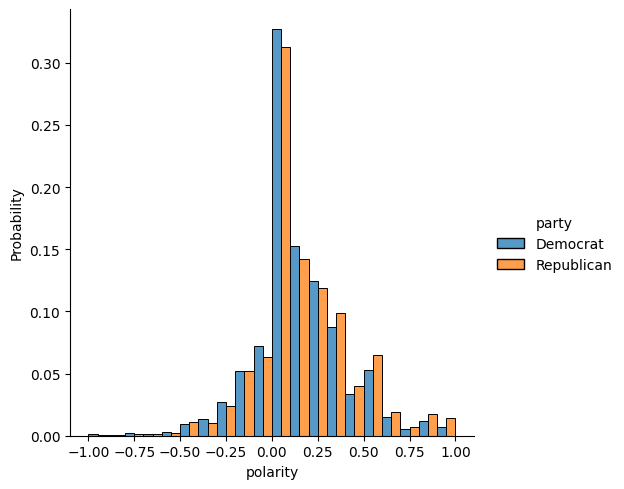

In [45]:
# plot sentiment polarity by party
## can the above observed pattern be generalized difference b/w the two parties? seems so
sns.displot(tweets,
            x = 'polarity',
            hue = 'party',
            multiple = 'dodge',
            stat = 'probability',
            common_norm = False,
            bins = 20);

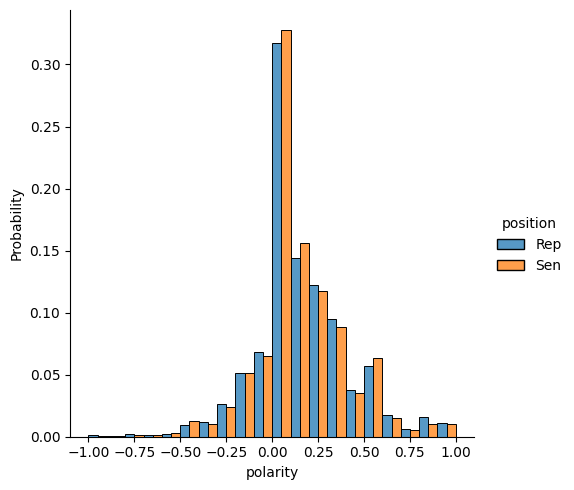

In [46]:
# plot sentiment polarity by position
## how about representatives vs. senators? the pattern is not as clear
sns.displot(tweets,
            x = 'polarity',
            hue = 'position',
            multiple = 'dodge',
            stat = 'probability',
            common_norm = False,
            bins = 20);

## 4. Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### 4.1. Engineered Text Features

In [47]:
# create word count
# ----
tweets['word_count'] = tweets['text'].apply(lambda x: len(x.split()))

In [48]:
# view (engineered text features: word_count, polarity, LDA topic distribution)
tweets[['text', 'word_count', 'polarity', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']]

,text,word_count,polarity,topic_0,topic_1,topic_2,topic_3,topic_4
0,Tune in to @MSNBC today at 11:30am for my segm...,26,0.0000,0.047957,0.813007,0.046392,0.046563,0.046081
1,"Calling all budding tech enthusiasts, coders, ...",24,0.0625,0.376300,0.053126,0.052830,0.464841,0.052902
2,Joining with @SpeakerPelosi and so many others...,29,0.2500,0.047438,0.047432,0.047091,0.046760,0.811278
3,"RT @zackhawkinsnc Dr. Ronda Taylor-Bullock, Ex...",40,0.0000,0.046342,0.046329,0.255984,0.605944,0.045401
4,#EndQualifiedImmunity and pass Rep. Pressley &...,37,0.0000,0.042785,0.826948,0.043409,0.043004,0.043853
...,...,...,...,...,...,...,...,...
14944,#LifeLibertyLevin starts NOW! Tune in to @FoxN...,10,0.0000,0.298036,0.512382,0.063141,0.063221,0.063220
14945,House Democrats are risking the safety and sec...,30,0.0000,0.043422,0.824713,0.043930,0.043671,0.044264
14946,NEWS: @JimInhofe Leads Letter Urging EPA to Co...,16,-0.2500,0.046149,0.047043,0.248515,0.046335,0.611958
14947,I had the pleasure of visiting with Ms. Barret...,61,0.2250,0.035641,0.037865,0.470225,0.420530,0.035739


In [49]:
# create X dataframe
# ----
X_engin = tweets[['word_count', 'polarity', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']]

### 4.2. TF-IDF 

In [50]:
# create tfidf dataframe (by the tfidf_df created in section 2.3.)
# ----
X_tfidf = tfidf_df

X_tfidf

,10,100,1000,10000,100000,100k,100th,101,102,1030,...,yovanovitch,yr,yrs,zachary,zelensky,zero,zip,zone,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.3 Word Embeddings

In [51]:
# load packages
# ----
import gensim
from gensim import models

In [52]:
# train a Word2Vec model
# ----
model = gensim.models.Word2Vec(
	tweets['tokens'],     # Data
	vector_size = 150,    # Number of dimensions for word embedding model 
	window = 5,           # Number of context words to observe in each direction
	min_count = 5,        # Minimum frequency for words included in model
	sg = 0,               # (Skip-Gram): ‘0’ indicates CBOW model; ‘1’ indicates Skip-Gram
	alpha = 0.025,        # Learning rate
	epochs = 5,           # Number of iterations
	seed = 224,           # Random seed 
	batch_words = 10000,  # Number of words to sample from data during each pass
	workers = 1)          # Set cores to 1 to ensure this embeddings are fully reproducible

In [53]:
# return list of words
words = list(model.wv.index_to_key)
print(words[0:100]) 

['rt', 'qt', 'today', 'work', 'need', 'help', 'thank', 'president', 'act', 'people', 'family', 'trump', 'time', 'community', 'year', 'bill', 'support', 'health', 'house', 'american', 'new', 'm', 'join', 'day', '"', 'great', 'congress', 'state', 'pass', 'americans', 'continue', 'vote', 'right', 'protect', 'care', 'country', 'business', 'week', 'fight', 's', 'life', '@realdonaldtrump', 'senate', 'national', 'federal', 'proud', 'job', 'service', 'million', 'good', '@covid19', 'like', 'nation', 'come', 'worker', 'honor', 'law', 'provide', 'america', 'know', '️', 'ensure', 'live', 'member', 'small', 'covid19', 'student', 'woman', 'democrats', 'crisis', 'public', 'program', 'legislation', 'want', 'security', 'discuss', 'important', 'bipartisan', 'include', 'government', 'school', 'office', 'safe', 'veteran', 'way', 'administration', 'hold', 'read', 'hear', 'pandemic', 'economy', 'stop', 'relief', 'watch', 'child', 'let', 'serve', 'issue', 'home', 'access']


In [55]:
# check (similarity b/w vectors)
## seems to make sense (as I expect a descending similarity b/w these pairs)
print(model.wv.similarity('covid19', '@covid19'), '\n',
      model.wv.similarity('covid19', 'health'), '\n',
      model.wv.similarity('covid19', 'business'), '\n',
      model.wv.similarity('covid19', 'bipartisan'), '\n',
      model.wv.similarity('covid19', 'senate'))

0.99098045 
 0.73757774 
 0.6576654 
 0.2666375 
 0.008010033


In [57]:
# check (semantic properties)
## trump - republican + democrat = ? (obama seems reasonable)
model.wv.most_similar(positive=['trump', 'democrat'], negative=['republican'])

[('@realdonaldtrump', 0.889400839805603),
 ('"', 0.8431368470191956),
 ('obama', 0.8247436881065369),
 ('election', 0.8202529549598694),
 ('trumps', 0.8199097514152527),
 ('political', 0.8193903565406799),
 ('ukraine', 0.8171904683113098),
 ('solicit', 0.8123511672019958),
 ('power', 0.8095943331718445),
 ('zelensky', 0.8070333003997803)]

In [63]:
# create a function that average the word embeddings at the document level
# ----
def document_vector(word2vec_model, doc):
    # check if doc is empty
    if not doc:
        print("Warning: Empty document! i =", i)
        return np.zeros(150)  # return an empty vector of length 150

    # filter out-of-vocabulary words
    valid_words = [w for w in doc if w in word2vec_model.wv.index_to_key]

    # check if all words are out-of-vocabulary
    if not valid_words:
        print("Warning: All words are out-of-vocabulary! i =", i)
        return np.zeros(150)

    # Calculate document vector using valid words
    return np.mean(word2vec_model.wv.__getitem__(valid_words), axis = 0)

In [64]:
# loop to create average word embedding vectors
# ----
X_awv = []

for i in range(0, len(tweets)): 
    X_awv.append(document_vector(model, tweets['tokens'][i]))

X_awv = pd.DataFrame(X_awv)
X_awv

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.142822,-0.019301,0.285115,0.132303,0.040007,-0.161824,-0.008681,-0.565368,0.040850,0.332645,...,0.315890,-0.035208,-0.258093,0.191768,-0.031158,-0.320716,-0.222001,0.089114,-0.183101,-0.039779
1,0.011351,0.025401,0.076927,0.196868,0.051574,-0.185788,-0.128587,-0.230781,0.058692,0.096000,...,0.164418,-0.123633,-0.129713,0.071038,-0.016004,-0.184834,-0.051503,0.129647,-0.157925,-0.128884
2,-0.199852,-0.082924,-0.055866,0.180952,-0.010440,-0.108596,0.040093,-0.586091,-0.067947,0.320485,...,0.352031,-0.297557,-0.245387,0.103975,0.048682,-0.266857,-0.121372,-0.073905,0.025103,0.115309
3,0.023856,0.041204,0.103955,0.264604,0.053050,-0.193567,-0.124523,-0.317329,0.136813,0.198251,...,0.289853,-0.128445,-0.159232,0.078240,-0.036406,-0.224746,-0.071603,0.068118,-0.165861,-0.133558
4,-0.306825,-0.058389,-0.099002,0.121574,-0.003179,-0.061601,0.059028,-0.663918,-0.198630,0.395281,...,0.380415,-0.358892,-0.347832,0.110560,0.062180,-0.312442,-0.145636,0.022662,0.007403,0.144515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14944,0.087788,0.087259,0.143290,0.167101,0.082287,-0.183475,-0.165646,-0.235297,0.042257,0.131393,...,0.226911,-0.020145,-0.169513,0.095417,-0.068817,-0.180998,-0.056251,0.167436,-0.229177,-0.134567
14945,-0.164726,-0.128367,-0.036690,0.242694,0.023114,-0.255525,0.051511,-0.581601,0.020090,0.243643,...,0.343273,-0.427418,-0.270577,0.105657,0.132734,-0.413567,-0.176460,0.022160,0.003412,0.007763
14946,-0.158391,-0.033502,-0.141414,0.302500,0.019499,-0.368923,-0.214197,-0.462028,-0.274236,0.182066,...,0.191298,-0.219455,-0.363161,0.098611,-0.049669,-0.289676,-0.031190,0.384380,-0.335643,-0.190164
14947,0.068671,0.058733,0.186444,0.293508,0.083320,-0.202730,-0.142767,-0.395312,0.123966,0.258233,...,0.350717,-0.118112,-0.192420,0.110195,-0.062004,-0.273248,-0.123831,0.103303,-0.246925,-0.142482


In [68]:
# check (25 tweets w/o valid words)
sum(X_awv[0] == 0)

25

## 5. Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### 5.1. Prediction Target

In [69]:
# load packages
# ----
from sklearn.preprocessing import LabelBinarizer

In [70]:
# finalize y 
# ----
lb = LabelBinarizer()

y_repub = lb.fit_transform(tweets['party'])
y_senat = lb.fit_transform(tweets['position'])

### 5.2. Six Text Models

In [71]:
# load packages
# ----
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [72]:
# set up loop variables
# ----
dataframes = [X_engin, X_tfidf, X_awv]
featurizations = ['Engineered Text Features (Republican=1)', 'TF-IDF (Republican=1)', 'Averaged Word Embeddings (Republican=1)']

accuracy score of Engineered Text Features (Republican=1) : 0.5769230769230769
accuracy score of TF-IDF (Republican=1) : 0.7598662207357859
accuracy score of Averaged Word Embeddings (Republican=1) : 0.5836120401337793


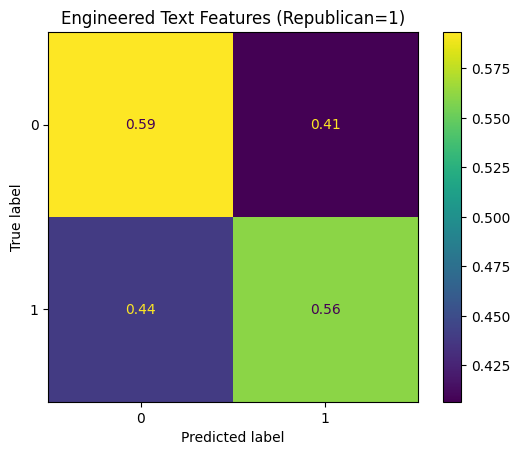

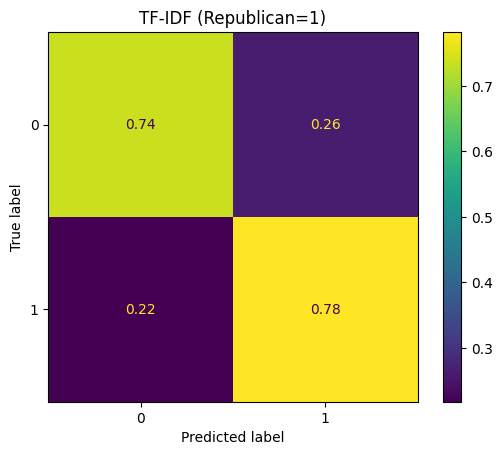

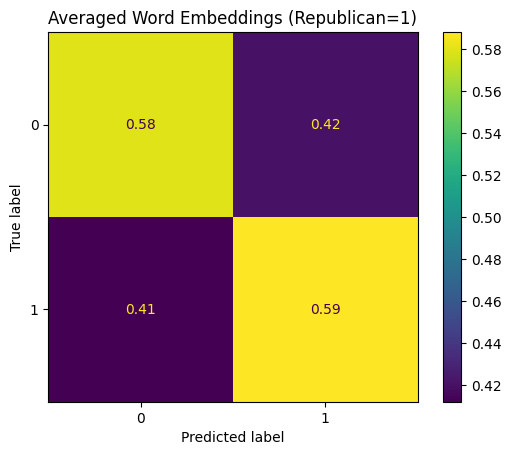

In [73]:
# classification model for Republican=1
# loop over each dataframe, apply a logit classification model, and create a confusion matrix
# ----
for dataframe, featurization in zip(dataframes, featurizations):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe, 
        y_repub,
        train_size = .80, 
        test_size = .20, 
        random_state = 224) 
    
    # fit logit model 
    logit = LogisticRegression(max_iter = 500)
    logit.fit(X_train,
              y_train.ravel())
    
    # create a confusion matrix
    y_pred = logit.predict(X_test)
    cm = confusion_matrix(y_test,
                          y_pred,
                          normalize = "true") 

    # plot
    ConfusionMatrixDisplay(cm).plot()
    plt.title(featurization);

    # print
    print('accuracy score of', featurization, ':', logit.score(X_test, y_test))

In [74]:
# change prediction target
# ----
dataframes = [X_engin, X_tfidf, X_awv]
featurizations = ['Engineered Text Features (senator=1)', 'TF-IDF (senator=1)', 'Averaged Word Embeddings (senator=1)']

accuracy score of Engineered Text Features (senator=1) : 0.754180602006689
accuracy score of TF-IDF (senator=1) : 0.7729096989966555
accuracy score of Averaged Word Embeddings (senator=1) : 0.754180602006689


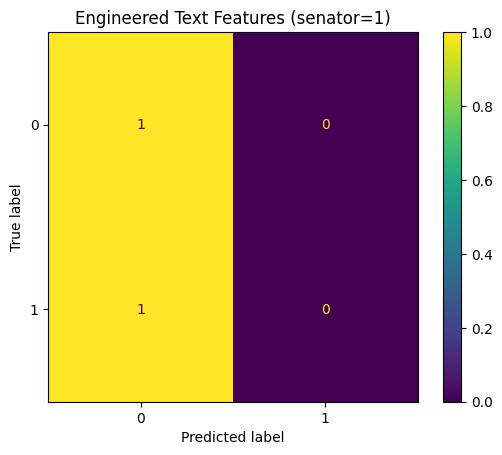

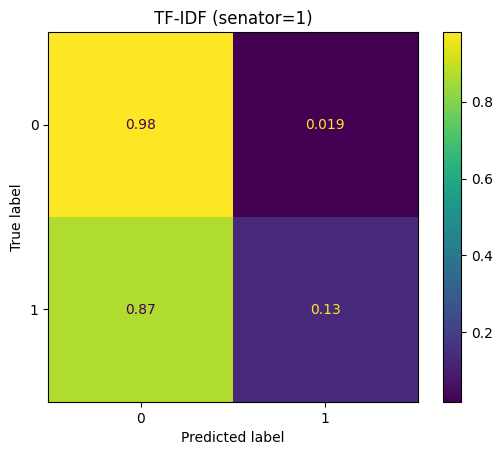

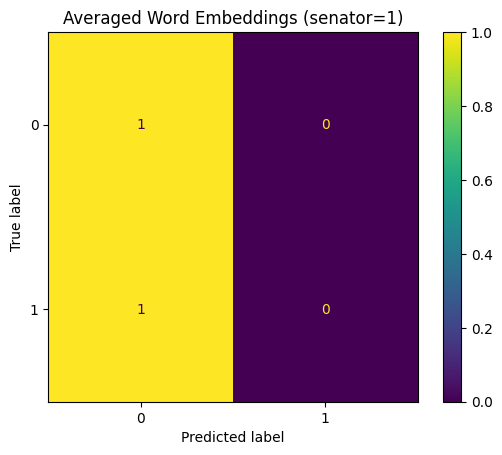

In [75]:
# classification model for senator=1
## these features are much worse at predicting senators vs. representatives
# ----
for dataframe, featurization in zip(dataframes, featurizations):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(dataframe,
                                                        y_senat,
                                                        train_size = .80,
                                                        test_size = .20, 
                                                        random_state = 224) 
    
    # fit logit model 
    logit = LogisticRegression(max_iter = 500)
    logit.fit(X_train,
              y_train.ravel())
    
    # create a confusion matrix
    y_pred = logit.predict(X_test)
    cm = confusion_matrix(y_test,
                          y_pred,
                          normalize = "true") 

    # plot
    ConfusionMatrixDisplay(cm).plot()
    plt.title(featurization);
    
    # print
    print('accuracy score of', featurization, ':', logit.score(X_test, y_test))

### 5.3. Two Combined Models

In [76]:
# check non-text features
tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_text', 'tokens_count',
       'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'polarity',
       'subjectivity', 'word_count'],
      dtype='object')

In [77]:
# create birth year variable
# ----
tweets['birth_yr'] = tweets['birthday'].map(lambda x: pd.to_numeric(x[-4:])) 
tweets[['birthday', 'birth_yr']].head()

,birthday,birth_yr
0,9/27/1954,1954
1,1/19/1972,1972
2,3/28/1953,1953
3,8/17/1940,1940
4,9/13/1976,1976


In [78]:
# code male=1 when gender=M
# ----
tweets['gender_male'] = lb.fit_transform(tweets['gender']) 
tweets[['gender', 'gender_male']].head()

,gender,gender_male
0,M,1
1,F,0
2,F,0
3,M,1
4,M,1


In [79]:
# create 2016 elction variable
# ----

# first turn it into integers 
tweets['trump_2016_num'] = tweets['trump_2016_state_share'].map(lambda x: pd.to_numeric(x.replace(',', '')))
tweets['clinton_2016_num'] = tweets['clinton_2016_state_share'].map(lambda x: pd.to_numeric(x.replace(',', '')))
tweets['romney_2012_num'] = tweets['romney_2012_state_share'].map(lambda x: pd.to_numeric(x.replace(',', '')))
tweets['obama_2012_num'] = tweets['obama_2012_state_share'].map(lambda x: pd.to_numeric(x.replace(',', '')))

# then divide them (rep_candidate / dem_candidate)
tweets['trump/clinton_2016_state'] = tweets['trump_2016_num'] / tweets['clinton_2016_num']
tweets['romney/obama_2012_state'] = tweets['romney_2012_num'] / tweets['obama_2012_num']

In [80]:
# combine best text features (tfidf) with non-text features
# ----
X_nt = tweets[['gender_male', 
               'birth_yr', 
               'trump/clinton_2016_state',
               'romney/obama_2012_state']]

X_com = X_nt.join(X_tfidf)

X_demog = tweets[['gender_male', 'birth_yr']].join(X_tfidf)

X_com

,gender_male,birth_yr,trump/clinton_2016_state,romney/obama_2012_state,10,100,1000,10000,100000,100k,...,yovanovitch,yr,yrs,zachary,zelensky,zero,zip,zone,zoom,zuckerberg
0,1,1954,0.618845,0.555188,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1972,0.745682,0.695293,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1953,0.618845,0.555188,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1940,1.079164,1.042235,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1976,0.512214,0.616219,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14944,1,1982,1.025064,0.982465,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14945,1,1962,1.507353,1.232162,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14946,1,1934,2.257832,2.009539,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14947,1,1954,1.938744,1.452092,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# set up loop variables
# ----
dataframes = [X_nt, X_com, X_tfidf, X_demog]
featurizations = ['Non-Text Features (Republican=1)', 'TF-IDF + Non-Text (Republican=1)', 'TF-IDF (Republican=1)', 'TF-IDF + Demographic (Republican=1)']

accuracy score of Non-Text Features (Republican=1) : 0.8234113712374582
accuracy score of TF-IDF + Non-Text (Republican=1) : 0.8575250836120402
accuracy score of TF-IDF (Republican=1) : 0.7598662207357859
accuracy score of TF-IDF + Demographic (Republican=1) : 0.6551839464882944


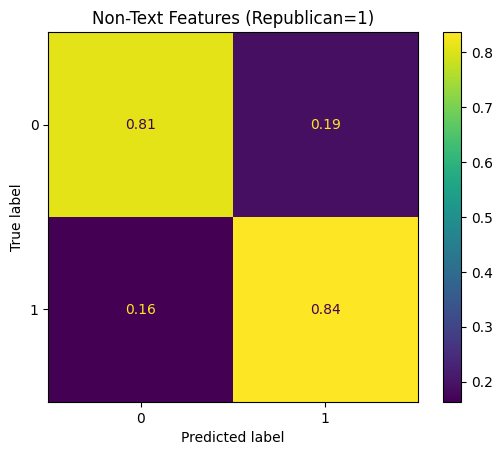

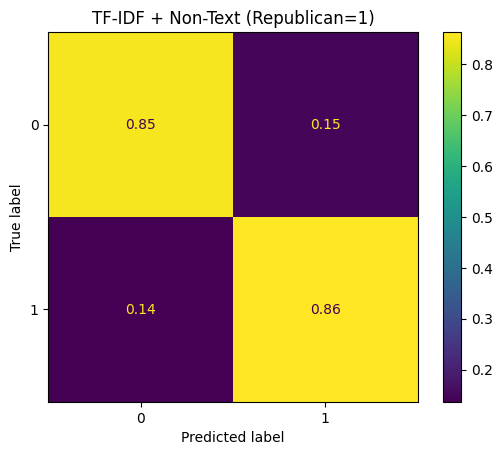

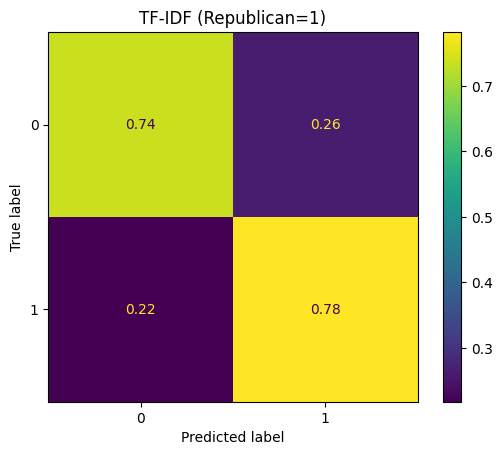

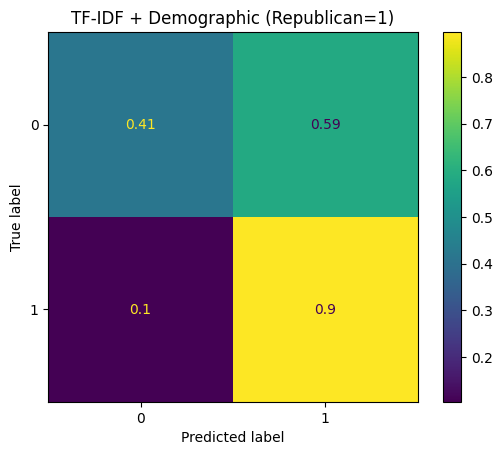

In [86]:
# classification model for Republican=1
# ----
for dataframe, featurization in zip(dataframes, featurizations):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe, 
        y_repub,
        train_size = .80, 
        test_size = .20, 
        random_state = 224) 
    
    # fit logit model 
    logit = LogisticRegression(max_iter = 500)
    logit.fit(X_train,
              y_train.ravel())
    
    # create a confusion matrix
    y_pred = logit.predict(X_test)
    cm = confusion_matrix(y_test,
                          y_pred,
                          normalize = "true") 

    # plot
    ConfusionMatrixDisplay(cm).plot()
    plt.title(featurization);

    # print
    print('accuracy score of', featurization, ':', logit.score(X_test, y_test))

In [87]:
# set up loop variables
# ----
dataframes = [X_nt, X_com, X_tfidf, X_demog]
featurizations = ['Non-Text Features (senator=1)', 'TF-IDF + Non-Text (senator=1)', 'TF-IDF (senator=1)', 'TF-IDF + Demographic (senator=1)']

accuracy score of Non-Text Features (senator=1) : 0.7525083612040134
accuracy score of TF-IDF + Non-Text (senator=1) : 0.7892976588628763
accuracy score of TF-IDF (senator=1) : 0.7729096989966555
accuracy score of TF-IDF + Demographic (senator=1) : 0.754180602006689


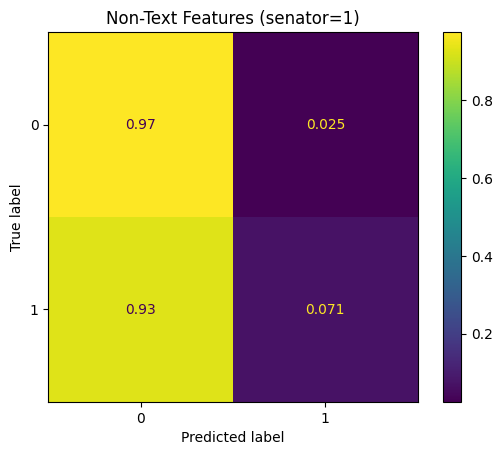

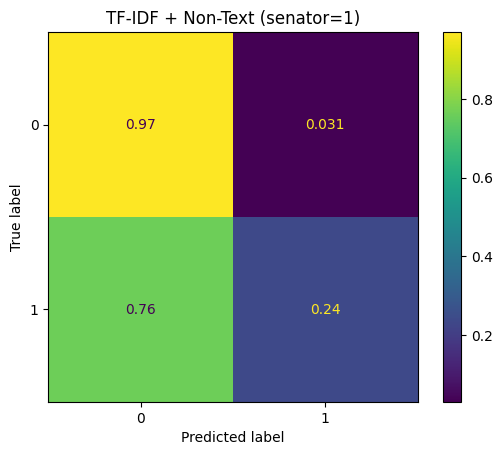

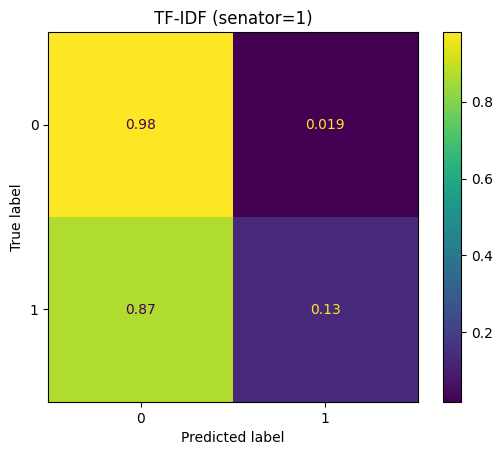

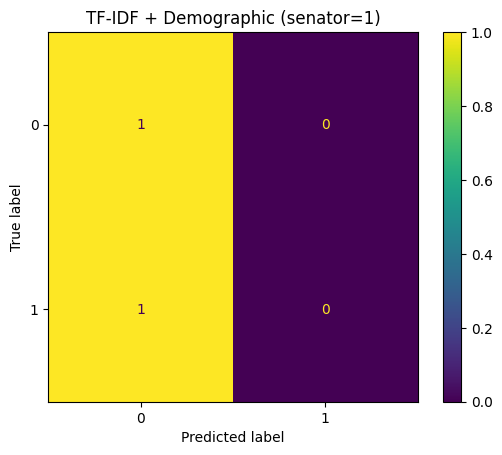

In [88]:
# classification model for senator=1
# ----
for dataframe, featurization in zip(dataframes, featurizations):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe, 
        y_senat,
        train_size = .80, 
        test_size = .20, 
        random_state = 224) 
    
    # fit logit model 
    logit = LogisticRegression(max_iter = 500)
    logit.fit(X_train,
              y_train.ravel())
    
    # create a confusion matrix
    y_pred = logit.predict(X_test)
    cm = confusion_matrix(y_test,
                          y_pred,
                          normalize = "true") 

    # plot
    ConfusionMatrixDisplay(cm).plot()
    plt.title(featurization);

    # print
    print('accuracy score of', featurization, ':', logit.score(X_test, y_test))

In [107]:
# logistic regression using non-text features 
# (to get an intuition at why non-text features work)
# ----
import statsmodels.api as sm

logit = sm.Logit(y_repub, sm.add_constant(X_nt)).fit()

print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.409643
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14949
Model:                          Logit   Df Residuals:                    14944
Method:                           MLE   Df Model:                            4
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                  0.4090
Time:                        16:46:11   Log-Likelihood:                -6123.8
converged:                       True   LL-Null:                       -10362.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -72.4360      4.053    -17.872      0.000     -80.380

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE:** Because every corpus has its idosyncrasies that without customization can degenerate the effectiveness of preprocessing strategies. For example, in this tweets data, words are often separated not by space (' ') but by line breakers (e.g., '\n'), thus words may be incorrectly agglomerated if line breakers are not replaced by space. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE:** Exploratory analysis in section 3 does suggest that, in general, Republicans have more positive sentiments in their tweets compared to Democrats. However, this sentiment difference is not clear when comparing Senators and Representatives.  

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE:** Supervised learning algorithms, here set by the classification task, provide an intuitive sense to how well our featurization is doing. When analyzing text data, the absence of the one best preprocessing strategy and featurization recipe can leave researchers in a quandary. Going back and forth between exploratory methods and classification tasks can help to supply better understanding of analytic processes. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE:** In terms of distinguishing Republicans tweets from Democrats tweets, TF-IDF provides a decent result: 76% accuracy in a balanced data. With non-text features only, however, I get a 82% accuracy score. This performace improvement seems to come mostly from two features: gender and state share of voting for trump divided by that of voting for clinton in 2016 presidential election, both are positively correlated with being a Republican (see logistic regression table in section 5.3). Combining non-text features with TF-IDF leads to a 86% accuracy score and is no doubt the model that performs the best. The intuition behind it is that the classification model based on non-text features (here gender, age, and presidential voting pattern in each state) is improved by the information provided by text data. 